# Lat-Lon Domains

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import jax
from jaxsw._src.domain.latlon import LatLonMeanDomain, LatLonDomain, lat_lon_deltas
from jaxsw._src.utils.coriolis import beta_plane, coriolis_param

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Latitude/Longitude Domains

Often we get data with spherical coordinates, i.e. latitude and longitude.
This will be common when working with **real data**. 
So we need some way to convert the coordinates into a box-like domain.

**Note**: We could try to use a method that handles spherical coordinates out of the box. 
However, this is not available in this package (at the moment). 
See the [xinvert](https://github.com/miniufo/xinvert) package for details. 
(Might add this in at a later date)

## Read input SSH

In [2]:
ds = xr.tutorial.open_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

In [3]:
lon = ds.lon.values
lat = ds.lat.values
sst = ds.sst[0].values.T

In [4]:
subset_ds = ds.sel(lat=slice(60, 20), lon=slice(125, 200)).isel(time=-1)
subset_ds

<xarray.Dataset>
Dimensions:    (lat: 21, lon: 38, nbnds: 2)
Coordinates:
  * lat        (lat) float32 60.0 58.0 56.0 54.0 52.0 ... 26.0 24.0 22.0 20.0
  * lon        (lon) float32 126.0 128.0 130.0 132.0 ... 194.0 196.0 198.0 200.0
    time       datetime64[ns] 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 ...
    sst        (lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

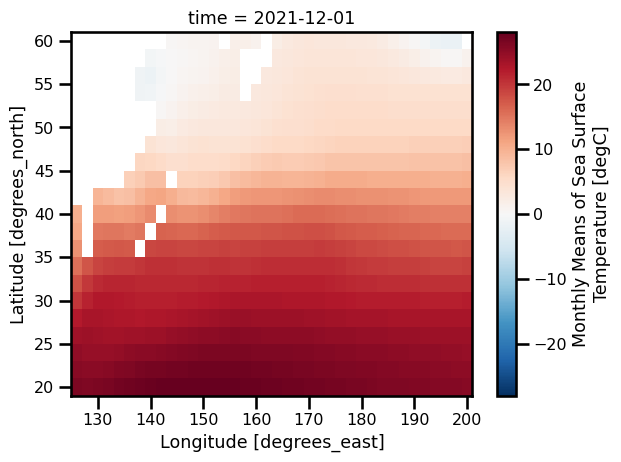

In [5]:
fig, ax = plt.subplots()


# ds.sst.isel(time=-1).plot.pcolormesh(cmap="RdBu_r")
subset_ds.sst.plot.pcolormesh(cmap="RdBu_r")
plt.tight_layout()
plt.show()

## Lat/Lon Domain

$$
\text{lat(m)} = 
$$

$$
d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [6]:
# from metpy.calc import lat_lon_grid_deltas
# out = lat_lon_grid_deltas(lon, lat)

We look at the [wiki page](https://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane) for the spherical Earth projected to a plane. Given some latitude, longitude pairs, $(\phi_1,\lambda_1), (\phi_2,\lambda_2)$, we can calculate the distance between them:

$$
\begin{aligned}
\Delta\phi &= \phi_2 - \phi_1 \\
\Delta\lambda &= \lambda_2 - \lambda_1
\end{aligned}
$$

We can also calculate the "mean" latitude

$$
\phi_m = \frac{\phi_1 + \phi_2}{2}
$$

Now we can calculate the distance between any set of points via the following formula:

$$
d = R \sqrt{(\Delta \phi)^2 + (cos(\phi_m)\Delta\lambda)^2}
$$

where $R$ is the radius of the Earth (6371200.0).


In [7]:
lon = subset_ds.lon.values
lat = subset_ds.lat.values

dx, dy = lat_lon_deltas(lon=lon, lat=lat)

print(dx.shape, dy.shape, lon.shape, lat.shape)

(38, 21) (38, 21) (38,) (21,)


$$
f_0 = 2\Omega\sin(\text{lat}\frac{\pi}{180})
$$

In [8]:
f = coriolis_param(lat)

f0 = jnp.mean(f)

print(f"Coriolis Param: {f0:.2e}")

Coriolis Param: 9.17e-05


This is very close to the parameter I've seen in simulations, i.e. $1e-5$

In [9]:
sst = jnp.asarray(subset_ds.sst[0].values.T)

## Convenience Class

In [10]:
lon = subset_ds.lon.values
lat = subset_ds.lat.values

domain = LatLonMeanDomain(lat=lat, lon=lon)

assert domain.size == (lon.shape[0], lat.shape[0])

domain.size, domain.dx

((38, 21), (Array(170366.08, dtype=float32), Array(222396.9, dtype=float32)))

Many times, we're using a lot of approximate methods for the discretization and many of them require some uniform grid.
There is a convenience method to simply take the mean of the dx.

In [11]:
domain.dx_mean

Array(196381.5, dtype=float32)